In [ ]:
from Bio import SeqIO
import pandas as pd
import re
import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pycirclize import Circos
from pycirclize.parser import Genbank
import numpy as np
import re


In [ ]:
def enzymes_from_pathway(pathway,table):
    s = KEGG()
    data = s.get(pathway)
    dict_data = s.parse(data)
    ec_numbers = []
    pattern = r'\[([^]]*)\]'
    for i in dict_data["ORTHOLOGY"].values():
        ec = re.search(pattern,i)
        if ec:
            ec_numbers.append(ec.group(1).split("EC:")[1])
    table = table.loc[table.EC_number.isin(ec_numbers)]
    return table

In [ ]:
minion_006 = pd.read_csv("../data/minion/PROKKA_11092023/PROKKA_11092023.tsv", sep = "\t")
pathway_ko00404 = enzymes_from_pathway("ko00404",minion_006) 

In [124]:
pathway_ko00404.head()

,locus_tag,ftype,length_bp,gene,EC_number,COG,product
398,ONHDLDEL_00399,CDS,417,metZ_1,2.5.1.-,NaN,O-succinylhomoserine sulfhydrylase
509,ONHDLDEL_00510,CDS,525,yfmJ,1.-.-.-,COG2130,Putative NADP-dependent oxidoreductase YfmJ
593,ONHDLDEL_00594,CDS,363,cmoM,2.1.1.-,COG0500,tRNA 5-carboxymethoxyuridine methyltransferase
998,ONHDLDEL_00999,CDS,459,ephD,1.-.-.-,COG1028,putative oxidoreductase EphD
1347,ONHDLDEL_01348,CDS,777,lvr_1,1.1.1.-,NaN,Levodione reductase


In [4]:
def features_from_gbk
gff_file = "../data/minion/PROKKA_11092023/PROKKA_11092023.gbk"

contig_length = {}
for record in SeqIO.parse(gff_file, "genbank"):
    contig_length[record.id] = int(len(record))
contids_list = list(contig_length.keys())


strand = []
locus = []
start_cds = []
end_cds = []
for record in SeqIO.parse(gff_file, "genbank"):
    contig_id = record.id
    for feature in record.features:
        if feature.type == "CDS":
            locus.append(feature.qualifiers["locus_tag"][0]) #tag
            strand.append(feature.location.strand) # tape sense
            #Start and end adjusted by contig length
            start = feature.location.start.position +1 
            end = feature.location.end.position - 1
            contig_index = contids_list.index(contig_id) + 1

            start_adjusted = start + sum(contig_length[f"contig_{c}"] for c in range(1,contig_index))
            end_adjusted = end + sum(contig_length[f"contig_{c}"] for c in range(1,contig_index))
            start_cds.append(start_adjusted)
            end_cds.append(end_adjusted)

gff_info = pd.DataFrame({
     "locus_tag":locus,
     "strand":strand,
     "start":start_cds,
     "end":end_cds
})
gff_info

In [5]:
features_from_gbk("../data/minion/PROKKA_11092023/PROKKA_11092023.gbk")

NameError: name 'SeqIO' is not defined

In [ ]:
#LOCATION OF ALL CDSs
# from Bio import SeqIO

# gff_file = "../data/minion/PROKKA_11092023/PROKKA_11092023.gbk"

# strand = []
# locus = []
# start = []
# end = []
# for record in SeqIO.parse(gff_file, "genbank"):
#     for feature in record.features:
#             if feature.type == "CDS":
#                 locus.append(feature.qualifiers["locus_tag"][0])
#                 strand.append(feature.location.strand)
#                 start.append(feature.location.start+3502)
#                 end.append(feature.location.end+3502)

# gff_info = pd.DataFrame({
#      "locus_tag":locus,
#      "strand":strand,
#      "start":start,
#      "end":end
# })

In [ ]:
#LOCATE ALL BGCs components
# bgcs_paths = glob.glob("../BGC/minion/contig_*")
# bgcs_df = pd.DataFrame()
# for file in bgcs_paths:
#     for record in SeqIO.parse(file,"genbank"):
#         prot = []
#         name = []
#         for feature in record.features:
#             if feature.type == "CDS":
#                 prot.append(feature.qualifiers["locus_tag"][0])
#                 name.append(file.split("/")[-1])
#         df = pd.DataFrame({"Id":name,"locus_tag":prot})
#     bgcs_df = pd.concat([bgcs_df,df], axis = 0)
# bgcs_df

In [ ]:
# bgcs_df = bgcs_df.loc[bgcs_df.Id == "contig_3.region001.gbk"]

In [ ]:
#Set colors for each BGCs
# colors = cm.get_cmap("tab10",len(bgcs_df.Id.unique()))
# region_colors = dict(zip(bgcs_df.Id.unique(),colors(range(len(bgcs_df.Id.unique())))))
# bgcs_df["color"] = bgcs_df["Id"].map(region_colors)
# bgcs_df.merge(gff_info, on = "locus_tag")


In [128]:
#Prepare tracks source
ko00404 = gff_info.loc[gff_info.locus_tag.isin(pathway_ko00404.locus_tag.values)] #PATHWAY

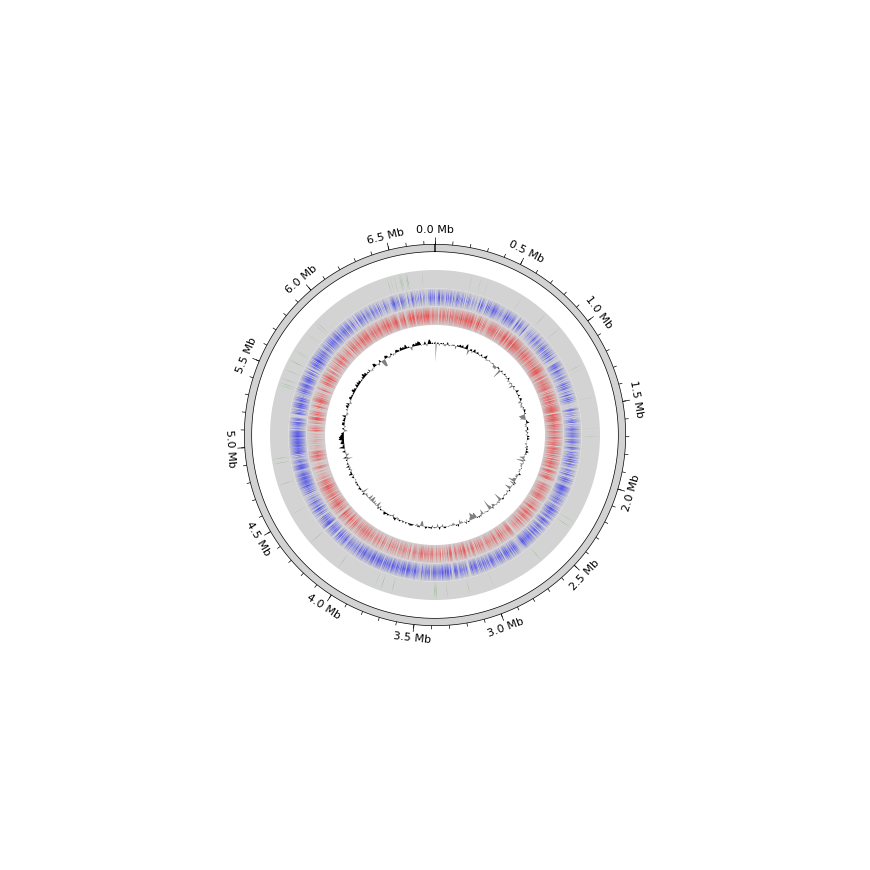

In [132]:

# bgcs_df_info = bgcs_df.merge(gff_info, on = "locus_tag")
# amr_info = deepsea_bra010.merge(gff_info, on = "locus_tag")

gbk = Genbank("../data/minion/PROKKA_11092023/PROKKA_11092023.gbk")

circos = Circos(sectors={gbk.name: gbk.range_size})
circos.text(" ", size=15)
sector = circos.sectors[0]

# Plot outer track with xticks
major_ticks_interval = 500000
minor_ticks_interval = 100000
outer_track = sector.add_track((50, 52))
outer_track.axis(fc="lightgrey")
outer_track.xticks_by_interval(
    major_ticks_interval, label_formatter=lambda v: f"{v/ 10 ** 6:.1f} Mb"
)
outer_track.xticks_by_interval(minor_ticks_interval, tick_length=1, show_label=False)

#Predicted CDS
cds_forward = sector.add_track((35,40))
cds_forward.axis(fc="lightgrey", ec="none")
for info in gff_info.itertuples():
     if info.strand == 1:
          cds_forward.arrow(start = info.start, end = info.end, color = "blue")

          
cds_reverse = sector.add_track((30,35))
cds_reverse.axis(fc="lightgrey", ec="none")
for info in gff_info.itertuples():
     if info.strand == -1:
          cds_reverse.arrow(start = info.end, end = info.start, color = "red")


pathway_ko00404_track = sector.add_track((40,45))
pathway_ko00404_track.axis(fc="lightgrey", ec="none")
for info in ko00404.itertuples():
    match info.strand:
        case 1:
            pathway_ko00404_track.arrow(start = info.start, end = info.end, color = "green")
        case -1:
            pathway_ko00404_track.arrow(start = info.end, end = info.start, color = "green")



# ko00930_track = sector.add_track((40, 45))
# ko00930_track.axis(fc="lightgrey", ec="none")
# for info in gff_info[gff_info.locus_tag.isin(ko00930_enzimes.locus_tag.to_list())].itertuples():
#     match info.strand:
#         case 1:
#             ko00930_track.arrow(start=info.start,end=info.end, color = "red")
#         case -1:
#             ko00930_track.arrow(start=info.end, end=info.start, color = "red")

#BGCS CIRCOS
# bgcs_track = sector.add_track((40,50))
# bgcs_track.axis(fc="lightgrey", ec="none")
# for info in bgcs_df_info.itertuples():
#         match info.strand:
#             case 1:
#                 bgcs_track.arrow(start=info.start,end=info.end, color = info.color)
#             case -1:
#                 bgcs_track.arrow(start=info.end, end=info.start, color = info.color)

#AMR CIRCOS
# amr_track = sector.add_track((30,35))
# amr_track.axis(fc="none", ec="none")
# for info in amr_info.itertuples():
#         match info.strand:
#             case 1:
#                 amr_track.arrow(start=info.start,end=info.end, color = "black", alpha = info.Pamr)
#             case -1:
#                 amr_track.arrow(start=info.end, end=info.start, color = "black", alpha = info.Pamr)



# Plot GC content

gc_content_track = sector.add_track((20, 30))
pos_list, gc_contents = gbk.calc_gc_content()
gc_contents = gc_contents - gbk.calc_genome_gc_content()
positive_gc_contents = np.where(gc_contents > 0, gc_contents, 0)
negative_gc_contents = np.where(gc_contents < 0, gc_contents, 0)
abs_max_gc_content = np.max(np.abs(gc_contents))
vmin, vmax = -abs_max_gc_content, abs_max_gc_content
gc_content_track.fill_between(
    pos_list, positive_gc_contents, 0, vmin=vmin, vmax=vmax, color="black"
)
gc_content_track.fill_between(
    pos_list, negative_gc_contents, 0, vmin=vmin, vmax=vmax, color="grey"
)


fig = circos.plotfig()
# BRA006/data/minion/PROKKA_11092023/PROKKA_11092023.gbk

In [121]:
6761687 - 6734372

27315

In [ ]:
names_mapp = {
     "Regulatory":"#a3ffac",
     "Other":"#c5c6c8",
     "Biosynthetic-additional": "#fabfb7",
     "Biosynthetic":"#ff6961",
     "Transport":"#b2e2f2",
}
# Criar uma lista de patches para a legenda
legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) for label, color in region_colors.items()]

# Criar a legenda
plt.legend(handles=legend_patches)

# Mostrar o gráfico vazio apenas para exibir a legenda
plt.axis('off')
plt.show()
# plt.savefig("legend_circos_bra010.svg", format = "svg", dpi = 1200)

In [ ]:
from dna_features_viewer import GraphicFeature, GraphicRecord

names_mapp = {
     "regulatory":"#a3ffac",
     "other":"#c5c6c8",
     "biosynthetic-additional": "#fabfb7",
     "biosynthetic":"#ff6961",
     "transport":"#b2e2f2",
     "resistance":"#4B0082"
}
features = []
for record in SeqIO.parse("antismash/contig_1.region007.gbk","genbank"):
    for info in record.features:
        if info.type == "CDS":
            if info.qualifiers["locus_tag"][0] == "ECAOCBJN_02852" or info.qualifiers["locus_tag"][0] == "ECAOCBJN_02853" or info.qualifiers["locus_tag"][0] == "ECAOCBJN_02864":
                features.append(
                GraphicFeature(
                    start=info.location.start, 
                    end=info.location.end, 
                    strand=info.location.strand, 
                    color=names_mapp["resistance"],
                    # label = info.qualifiers["locus_tag"][0]
                    ))
            else:
                try:
                    color = names_mapp[info.qualifiers["gene_functions"][0].split(" ")[0]]
                    features.append(
                    GraphicFeature(
                        start=info.location.start, 
                        end=info.location.end, 
                        strand=info.location.strand, 
                        color=color,
                        # label = info.qualifiers["locus_tag"][0]
                        ))
                except:
                    pass
                    # color = names_mapp["other"]
                    # features.append(
                    # GraphicFeature(
                    #     start=info.location.start, 
                    #     end=info.location.end, 
                    #     strand=info.location.strand, 
                    #     color=color))


record = GraphicRecord(sequence_length = 81380, features=features)
record.plot(figure_width=20)
plt.savefig("bra010_bgc7.svg",format = "svg", dpi = 1200)